# Calculating tide statistics and satellite biases

## Load satellite data using odc-stac



In [1]:
import odc.stac
import pystac_client

# Connect to STAC catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    datetime="2024-01-01/2024-12-31",
)

# Load data into xarray format
ds = odc.stac.load(
    items=list(query.items()),
    bands=["nbart_red", "nbart_green", "nbart_blue"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds)

<xarray.Dataset> Size: 108MB
Dimensions:      (y: 371, x: 356, time: 68)
Coordinates:
  * y            (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x            (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 544B 2024-01-07T01:55:31.679580 ... 20...
Data variables:
    nbart_red    (time, y, x) float32 36MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>
    nbart_green  (time, y, x) float32 36MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 36MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


## Using tide_stats

Using tide modelling location: 122.21, -18.00
Modelling tides using EOT20
Modelling tides using EOT20

63% of the 9.89 m modelled astronomical tidal range is observed at this location.
The lowest 24% and highest 12% of astronomical tides are never observed.



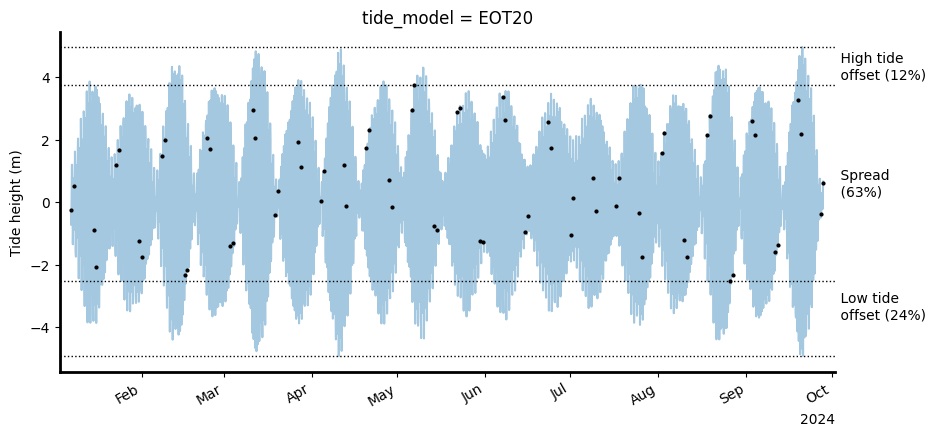

In [2]:
from eo_tides.stats import tide_stats

statistics_df = tide_stats(
    ds,
    directory="../../tests/data/tide_models",
)